Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
def download_data(url, filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

In [3]:
filename = download_data(url='http://mattmahoney.net/dc/', filename='text8.zip', expected_bytes=31344016)

Found and verified text8.zip


Read the data into a list of strings.

In [4]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data

In [5]:
words = read_data(filename)

In [6]:
print("words.type=", type(words))
print('words.size=', len(words))
print("words[:50]=", words[:50])

words.type= <class 'list'>
words.size= 17005207
words[:50]= ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the']


Build the dictionary and replace rare words with UNK token.

Use collections.Counter function to create the dictionary.

In [8]:
help(collections.Counter)

Help on class Counter in module collections:

class Counter(builtins.dict)
 |  Dict subclass for counting hashable items.  Sometimes called a bag
 |  or multiset.  Elements are stored as dictionary keys and their counts
 |  are stored as dictionary values.
 |  
 |  >>> c = Counter('abcdeabcdabcaba')  # count elements from a string
 |  
 |  >>> c.most_common(3)                # three most common elements
 |  [('a', 5), ('b', 4), ('c', 3)]
 |  >>> sorted(c)                       # list all unique elements
 |  ['a', 'b', 'c', 'd', 'e']
 |  >>> ''.join(sorted(c.elements()))   # list elements with repetitions
 |  'aaaaabbbbcccdde'
 |  >>> sum(c.values())                 # total of all counts
 |  15
 |  
 |  >>> c['a']                          # count of letter 'a'
 |  5
 |  >>> for elem in 'shazam':           # update counts from an iterable
 |  ...     c[elem] += 1                # by adding 1 to each element's count
 |  >>> c['a']                          # now there are seven 'a'
 |  7
 

In [9]:
c = collections.Counter('abcdeabcdabcaba')
c

Counter({'a': 5, 'b': 4, 'c': 3, 'd': 2, 'e': 1})

In [10]:
print("words 0-19 :", words[:20])
collections.Counter(words[:20])

words 0-19 : ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']


Counter({'a': 1,
         'abuse': 1,
         'against': 1,
         'anarchism': 1,
         'as': 1,
         'class': 1,
         'diggers': 1,
         'early': 1,
         'english': 1,
         'first': 1,
         'including': 1,
         'of': 2,
         'originated': 1,
         'radicals': 1,
         'term': 1,
         'the': 2,
         'used': 1,
         'working': 1})

In [11]:
collections.Counter(words[:100]).most_common(5)

[('the', 9), ('a', 4), ('of', 4), ('used', 3), ('anarchism', 3)]

In [14]:
count = [['UNK', -1]]
type(count)

list

In [17]:
count[0][1]

-1

In [19]:
vocabulary_size = 50
count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
count

[['UNK', -1],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430),
 ('two', 192644),
 ('is', 183153),
 ('as', 131815),
 ('eight', 125285),
 ('for', 118445),
 ('s', 116710),
 ('five', 115789),
 ('three', 114775),
 ('was', 112807),
 ('by', 111831),
 ('that', 109510),
 ('four', 108182),
 ('six', 102145),
 ('seven', 99683),
 ('with', 95603),
 ('on', 91250),
 ('are', 76527),
 ('it', 73334),
 ('from', 72871),
 ('or', 68945),
 ('his', 62603),
 ('an', 61925),
 ('be', 61281),
 ('this', 58832),
 ('which', 54788),
 ('at', 54576),
 ('he', 53573),
 ('also', 44358),
 ('not', 44033),
 ('have', 39712),
 ('were', 39086),
 ('has', 37866),
 ('but', 35358),
 ('other', 32433),
 ('their', 31523),
 ('its', 29567),
 ('first', 28810),
 ('they', 28553),
 ('some', 28161),
 ('had', 28100)]

In [22]:
  for word, a in count:
    print(word, a)

UNK -1
the 1061396
of 593677
and 416629
one 411764
in 372201
a 325873
to 316376
zero 264975
nine 250430
two 192644
is 183153
as 131815
eight 125285
for 118445
s 116710
five 115789
three 114775
was 112807
by 111831
that 109510
four 108182
six 102145
seven 99683
with 95603
on 91250
are 76527
it 73334
from 72871
or 68945
his 62603
an 61925
be 61281
this 58832
which 54788
at 54576
he 53573
also 44358
not 44033
have 39712
were 39086
has 37866
but 35358
other 32433
their 31523
its 29567
first 28810
they 28553
some 28161
had 28100


In [32]:
vocabulary_size = 20 # 50000

In [33]:
def build_dataset(words):
  
  # Create a list 'count' containing tuples (word, number_of_words)
  # The first element of the list 'count' is the word 'unknown'
  count = [['UNK', -1]]

  # Extend the list 'count' with the X-1 most common words
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    
  dictionary = dict()

  # Walk through each tuple of the list 'count' 
  # _ is for the second parameter of the tuple, i.e. 'number of words'
  for word, _ in count:
    dictionary[word] = len(dictionary)
    
  # the index between the words and the dictionary
  data = list()

  # the number of unknown words
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      # count the number of unknown words 
      unk_count = unk_count + 1
    data.append(index)
    
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 

  return data, count, dictionary, reverse_dictionary

In [34]:
help(zip)

Help on class zip in module builtins:

class zip(object)
 |  zip(iter1 [,iter2 [...]]) --> zip object
 |  
 |  Return a zip object whose .__next__() method returns a tuple where
 |  the i-th element comes from the i-th iterable argument.  The .__next__()
 |  method continues until the shortest iterable in the argument sequence
 |  is exhausted and then it raises StopIteration.
 |  
 |  Methods defined here:
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __next__(self, /)
 |      Implement next(self).
 |  
 |  __reduce__(...)
 |      Return state information for pickling.



In [35]:
dict(zip([1, 2, 3], ['A', 'B', 'C']))


{1: 'A', 2: 'B', 3: 'C'}

In [36]:
data, count, dictionary, reverse_dictionary = build_dataset(words)

# Reduce memory consumption by removing words list
del words

In [42]:
print("\ndata:", data[:10])
print("\ncount:", count[:10])
print("\ndictionary:", dictionary)
print("\nreverse_dictionary:", reverse_dictionary)


data: [0, 0, 12, 6, 0, 2, 0, 46, 0, 0]

count: [['UNK', 9915444], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]

dictionary: {'three': 17, 'six': 22, 'nine': 9, 'its': 45, 'not': 38, 'eight': 13, 'his': 30, 'he': 36, 'from': 28, 'for': 14, 'the': 1, 'but': 42, 'to': 7, 'five': 16, 'this': 33, 'in': 5, 'a': 6, 'on': 25, 'was': 18, 'or': 29, 'with': 24, 'be': 32, 'seven': 23, 'first': 46, 'four': 21, 'is': 11, 's': 15, 'two': 10, 'and': 3, 'that': 20, 'are': 26, 'their': 44, 'also': 37, 'of': 2, 'at': 35, 'as': 12, 'have': 39, 'zero': 8, 'had': 49, 'it': 27, 'one': 4, 'they': 47, 'which': 34, 'UNK': 0, 'some': 48, 'an': 31, 'other': 43, 'has': 41, 'were': 40, 'by': 19}

reverse_dictionary: {0: 'UNK', 1: 'the', 2: 'of', 3: 'and', 4: 'one', 5: 'in', 6: 'a', 7: 'to', 8: 'zero', 9: 'nine', 10: 'two', 11: 'is', 12: 'as', 13: 'eight', 14: 'for', 15: 's', 16: 'five', 17: 'three', 18: 'was',

In [28]:
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
print('dictionary anarchism =', dictionary['anarchism'], 'originated =', dictionary['originated'])
print('reverse_dictionary 5244 =', reverse_dictionary[5244], "3084 =", reverse_dictionary[3084], " 12 =", reverse_dictionary[12])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5244, 3084, 12, 6, 195, 2, 3136, 46, 59, 156]
dictionary anarchism = 5244 originated = 3084
reverse_dictionary 5244 = anarchism 3084 = originated  12 = as


Function to generate a training batch for the skip-gram model.

In [29]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index

  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window

  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)

  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  
  return batch, labels

In [44]:
print('data:', data[:8])
print('decoded data:', [reverse_dictionary[di] for di in data[:8]])

data: [0, 0, 12, 6, 0, 2, 0, 46]
decoded data: ['UNK', 'UNK', 'as', 'a', 'UNK', 'of', 'UNK', 'first']


In [43]:
for num_skips, skip_window in [(2, 1), (4, 2)]:
    print("num_skips:", num_skips, "skip_window:", skip_window)

num_skips: 2 skip_window: 1
num_skips: 4 skip_window: 2


In [32]:
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])


with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['originated', 'term', 'anarchism', 'a', 'of', 'term', 'as', 'originated']


Train a skip-gram model.

In [33]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [13]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.385003
Nearest to can: shortwave, batting, eben, haiti, uk, breakbeat, sive, floyd,
Nearest to system: bookshelf, laing, brian, undercover, elaborates, sveriges, thyroxine, contradicts,
Nearest to zero: soddy, dossier, fhm, fountain, ccf, lusitania, criminology, casualties,
Nearest to d: vagus, antinous, grits, navarro, cameroonian, tuned, bakr, milling,
Nearest to six: laden, canned, cystitis, oed, mogadishu, attendant, distinctively, schneier,
Nearest to between: rerio, icing, platter, fusion, savanna, ankles, blames, militiamen,
Nearest to many: couple, biologist, connor, spoke, sector, suu, older, life,
Nearest to during: good, retitled, ago, kees, hoosiers, venatici, quaker, fixing,
Nearest to some: vespasian, uncover, material, selects, bodyguards, sandbox, arles, pamphlets,
Nearest to more: containing, massif, om, clouds, deut, ensue, medallist, taken,
Nearest to be: ribosomes, decomposition, anacondas, compaq, pointy, sabotage, algebras, be

In [14]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

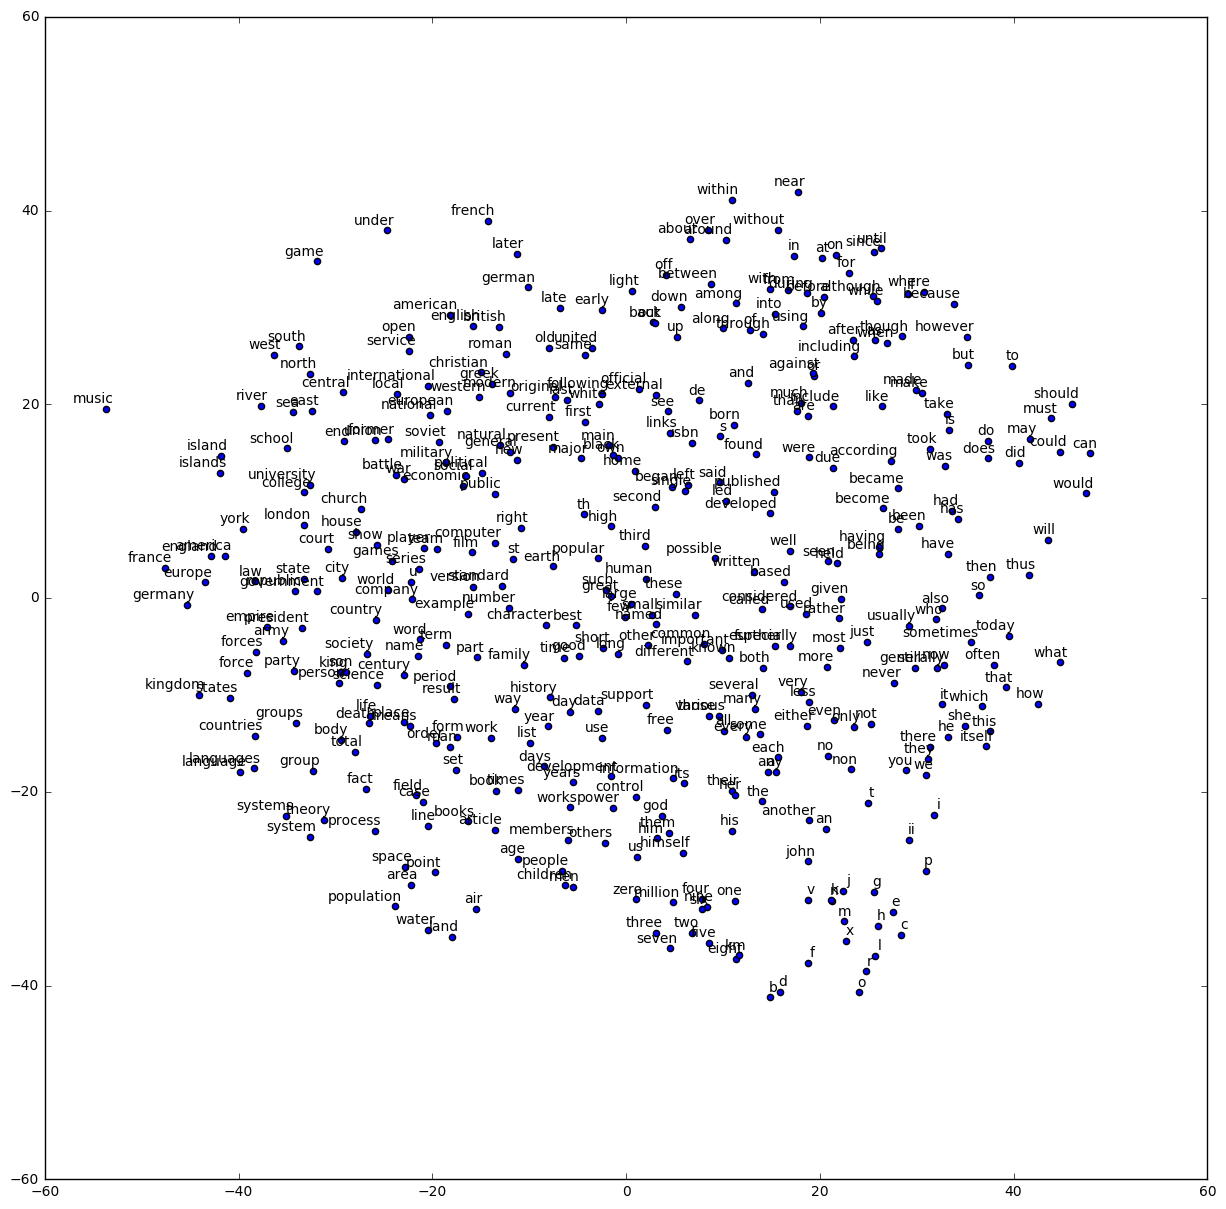

In [15]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---